# BTC-USD @24h

In [1]:
# PARAMS:
BC24H_FILENAME = './data_clean/btc_usd_24h_bitstamp.csv'
OUT_FILENAME = './results/btc24h_c.csv'
OUT_RETRAINED_FILENAME = './results/btc24h_c.ret.csv'
# TL;DR change params & Kernel > Restart & Run All to "run this like a script"

In [2]:
# autoreload
%load_ext autoreload
%autoreload 1
# write code that works in both Python 2 (2.7+) and 3 (3.5+)
from __future__ import absolute_import, division, print_function, unicode_literals
try:
    input = raw_input
    range = xrange
except NameError:
    pass

In [3]:
import csv
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import keras
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

import pprint
pp = pprint.PrettyPrinter(indent=2).pprint
from IPython.display import display as dd
from IPython.display import Image

%matplotlib inline

/home/paperspace/anaconda3/envs/py27/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
%aimport lib.helpers
%aimport lib.etl
%aimport lib.visualization
%aimport lib.walk_forward_predict
%aimport models.rnn
%aimport models.lr
from lib.helpers import (
    timing, print_shapes, fix_all_rngs,
    date_str_to_ts
)
from lib.visualization import simple_plot
from lib.walk_forward_predict import (
    run_walk_forward_validation_rnn,
    run_walk_forward_validation_arima,
    run_walk_forward_validation_rnn_retraining
)
import lib.etl as etl
from models.rnn import make_rnn_model_constructor
from models.lr import LRModel

/home/paperspace/anaconda3/envs/py27/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


> size: 1351


close      float64
open       float64
high       float64
low        float64
volume     float64
missing      int64
dtype: object

,close,open,high,low,volume,missing
datetime,,,,,,
2015-02-01,214.8,218.0,220.8,208.5,6.19,0
2015-02-02,238.0,214.8,242.0,214.8,6.42,0
2015-02-03,227.4,238.0,244.4,223.8,17.76,0
2015-02-04,227.0,227.4,231.0,220.0,14.31,0
2015-02-05,217.0,227.0,228.9,213.6,4.31,0


,close,open,high,low,volume,missing
datetime,,,,,,
2018-10-09,6588.8,6604.8,6623.1,6553.1,2.25,0
2018-10-10,6517.5,6588.7,6589.8,6400.0,5.18,0
2018-10-11,6161.0,6517.5,6518.4,6067.0,9.62,0
2018-10-12,6184.9,6152.8,6238.3,6109.8,3.25,0
2018-10-13,6195.0,6180.8,6214.1,6168.8,2.27,0


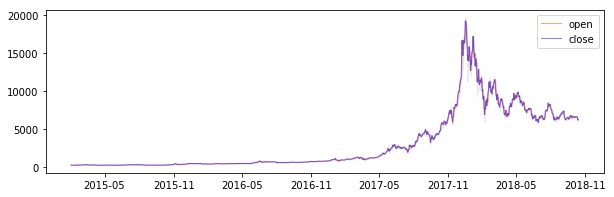

In [5]:
data24h = pd.read_csv(
    BC24H_FILENAME,
    index_col='datetime',
    parse_dates=['datetime']
)
print('> size:', len(data24h))
dd(data24h.dtypes)
dd(data24h.head())
dd(data24h.tail())
simple_plot(data24h, show_xlabels=False)

In [6]:
data24h['weekday'] = data24h.index.dayofweek
data24h.head()

,close,open,high,low,volume,missing,weekday
datetime,,,,,,,
2015-02-01,214.8,218.0,220.8,208.5,6.19,0,6
2015-02-02,238.0,214.8,242.0,214.8,6.42,0,0
2015-02-03,227.4,238.0,244.4,223.8,17.76,0,1
2015-02-04,227.0,227.4,231.0,220.0,14.31,0,2
2015-02-05,217.0,227.0,228.9,213.6,4.31,0,3


## Test runs

### LSTM

### `7|0.1|7|0.1`

**Conclusion:** This gives "best" results with 3 to 5 epoch... but they are simply too random. "Stable" results are only achieved at 6 to 10 epochs, but they are much worse.

data ~ (600, 1)
--- 0.018s to model compilation time


--- Created model id: 140667160038416
Tensor("lstm_7_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 7, 7)              252       
_________________________________________________________________
dropout_7 (Dropout)          (None, 7, 7)              0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 7)                 420       
_________________________________________________________________
dropout_8 (Dropout)          (None, 7)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 8         
Total params: 680
Trainable params: 680
Non-trainable params: 0
____________________________________________________________

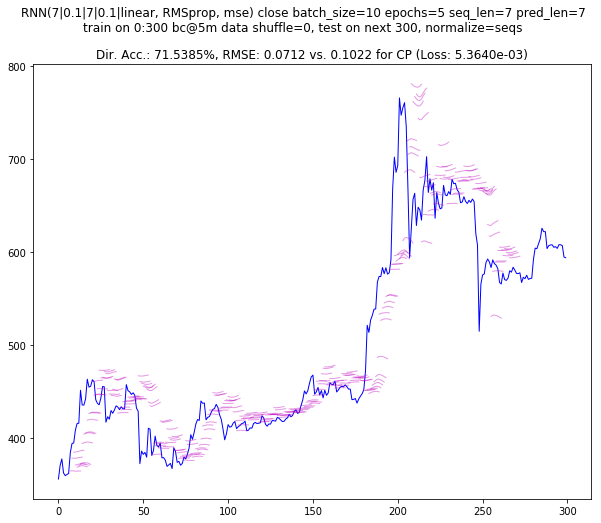

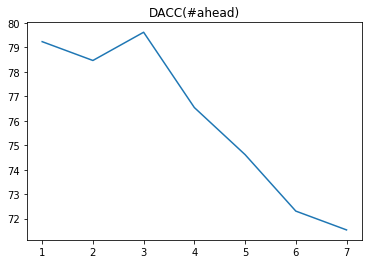

--- 5.425s to run experiment



In [11]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data24h,
        features=['close'],
        from_i=0,
        train_sz=300,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor([7, 0.1, 7, 0.1]),
        # training:
        epochs=5,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=1,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

data ~ (600, 1)
--- 0.020s to model compilation time


--- Created model id: 140666951454928
Tensor("lstm_15_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 7, 7)              252       
_________________________________________________________________
dropout_15 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_16 (Dropout)         (None, 7)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 8         
Total params: 680
Trainable params: 680
Non-trainable params: 0
___________________________________________________________

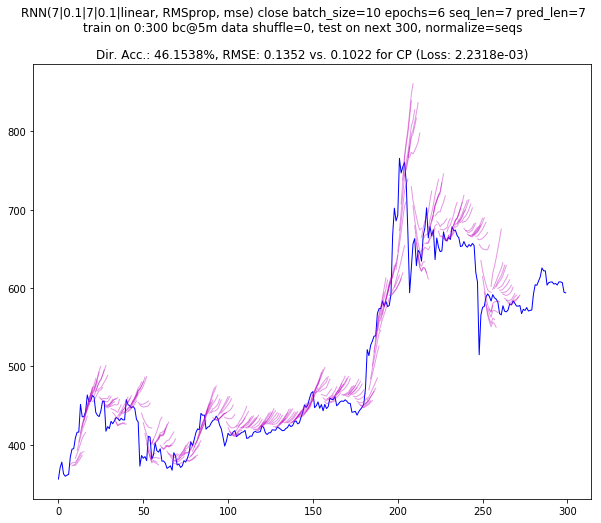

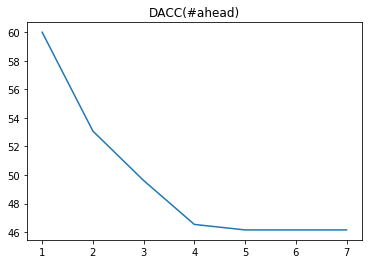

--- 7.217s to run experiment



In [16]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data24h,
        features=['close'],
        from_i=0,
        train_sz=300,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor([7, 0.1, 7, 0.1]),
        # training:
        epochs=6,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=1,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

data ~ (600, 1)
--- 0.017s to model compilation time


--- Created model id: 140666865586960
Tensor("lstm_23_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_23 (LSTM)               (None, 7, 7)              252       
_________________________________________________________________
dropout_23 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_24 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_24 (Dropout)         (None, 7)                 0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 8         
Total params: 680
Trainable params: 680
Non-trainable params: 0
___________________________________________________________

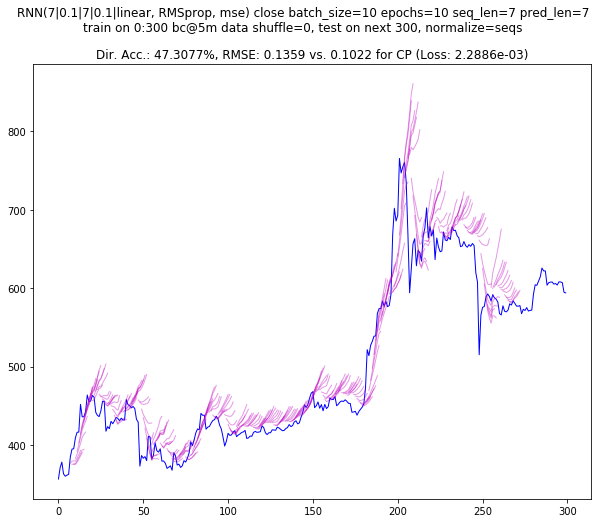

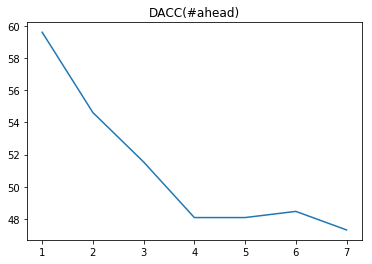

--- 9.233s to run experiment



In [20]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data24h,
        features=['close'],
        from_i=0,
        train_sz=300,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor([7, 0.1, 7, 0.1]),
        # training:
        epochs=10,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=1,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

### 3|0.1|3|0.1

**Conclusion:** Amazingly, this smaller networks gives better results than the larger ones. Best at 3 epochs.

data ~ (600, 1)
--- 0.018s to model compilation time


--- Created model id: 140666688094096
Tensor("lstm_43_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_43 (LSTM)               (None, 7, 3)              60        
_________________________________________________________________
dropout_43 (Dropout)         (None, 7, 3)              0         
_________________________________________________________________
lstm_44 (LSTM)               (None, 3)                 84        
_________________________________________________________________
dropout_44 (Dropout)         (None, 3)                 0         
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 4         
Total params: 148
Trainable params: 148
Non-trainable params: 0
___________________________________________________________

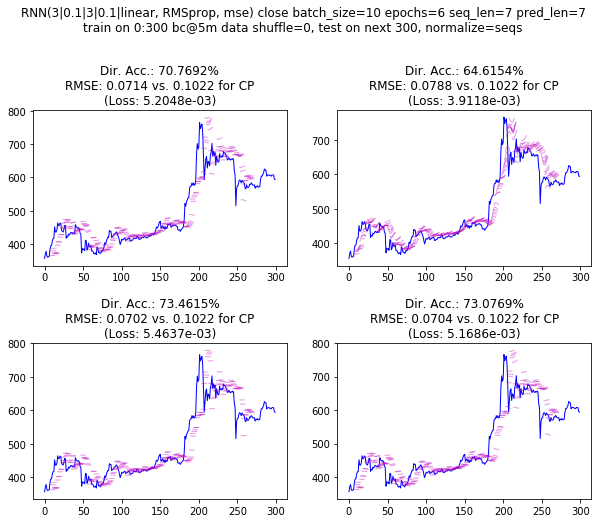

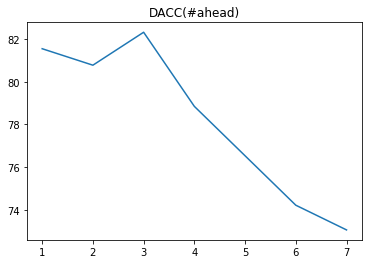

--- 39.065s to run experiment



In [27]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data24h,
        features=['close'],
        from_i=0,
        train_sz=300,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor([3, 0.1, 3, 0.1]),
        # training:
        epochs=6,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

data ~ (600, 1)
--- 0.016s to model compilation time


--- Created model id: 140666600637968
Tensor("lstm_51_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_51 (LSTM)               (None, 7, 3)              60        
_________________________________________________________________
dropout_51 (Dropout)         (None, 7, 3)              0         
_________________________________________________________________
lstm_52 (LSTM)               (None, 3)                 84        
_________________________________________________________________
dropout_52 (Dropout)         (None, 3)                 0         
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 4         
Total params: 148
Trainable params: 148
Non-trainable params: 0
___________________________________________________________

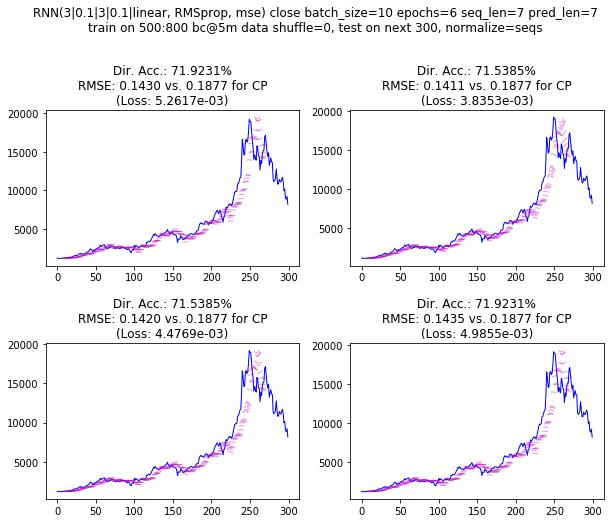

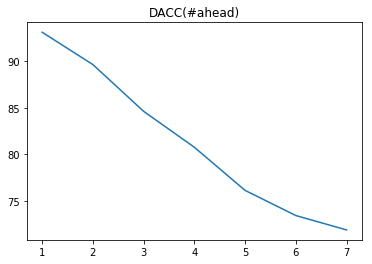

--- 44.567s to run experiment



In [28]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data24h,
        features=['close'],
        from_i=500,
        train_sz=300,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor([3, 0.1, 3, 0.1]),
        # training:
        epochs=6,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

data ~ (600, 1)
--- 0.055s to model compilation time


--- Created model id: 140665675744528
Tensor("lstm_155_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_155 (LSTM)              (None, 7, 3)              60        
_________________________________________________________________
dropout_155 (Dropout)        (None, 7, 3)              0         
_________________________________________________________________
lstm_156 (LSTM)              (None, 3)                 84        
_________________________________________________________________
dropout_156 (Dropout)        (None, 3)                 0         
_________________________________________________________________
dense_78 (Dense)             (None, 1)                 4         
Total params: 148
Trainable params: 148
Non-trainable params: 0
__________________________________________________________

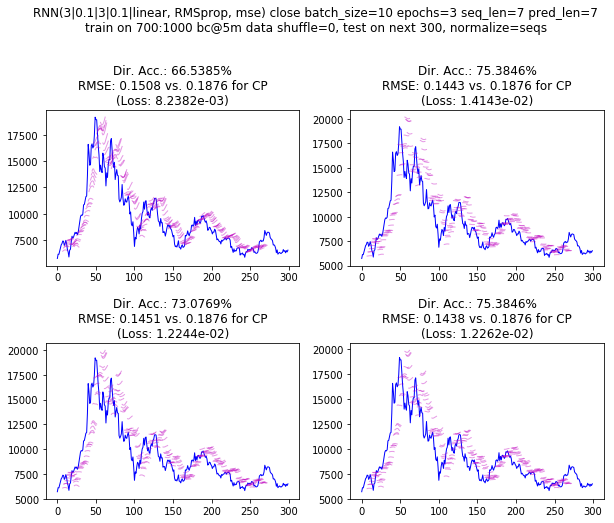

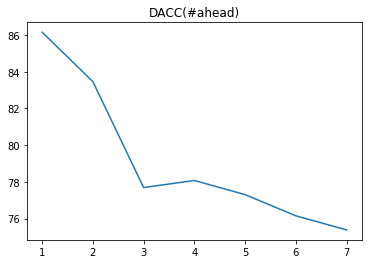

--- 188.970s to run experiment



In [41]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data24h,
        features=['close'],
        from_i=700,
        train_sz=300,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor([3, 0.1, 3, 0.1]),
        # training:
        epochs=3,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

In [ ]:
with timing('run experiment'):
    run_walk_forward_validation_rnn_retraining(
        # data to extract:
        data24h,
        features=['close'],
        from_i=0,
        train_sz=300,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor([3, 0.1, 3, 0.1]),
        # training:
        epochs=6,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

data ~ (600, 1)

====== 0
                x_train_seqs ~ (292, 7, 1) [...0.0101538461538]
                y_train ~ (292, 1) [...[0.09661538]]
                x_test_seqs ~ (1, 7, 1) [...0.0165544332211]
                y_test ~ (1, 1) [...[0.07940516]]
                
--- 0.015s to model compilation time


--- Created model id: 140210297286032
Tensor("lstm_1_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 7, 3)              60        
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 3)              0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 3)                 84        
_________________________________________________________________
dropout_2 (Dropout)          (None, 3)                 0         
_

### 14|0.1|14|0.1

**Conclusion:** Amazingly, this smaller networks gives better results than the larger ones. Best at 3 epochs.

data ~ (600, 1)
--- 0.018s to model compilation time


--- Created model id: 140665388567568
Tensor("lstm_187_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_187 (LSTM)              (None, 7, 7)              252       
_________________________________________________________________
dropout_187 (Dropout)        (None, 7, 7)              0         
_________________________________________________________________
lstm_188 (LSTM)              (None, 14)                1232      
_________________________________________________________________
dropout_188 (Dropout)        (None, 14)                0         
_________________________________________________________________
dense_94 (Dense)             (None, 1)                 15        
Total params: 1,499
Trainable params: 1,499
Non-trainable params: 0
______________________________________________________

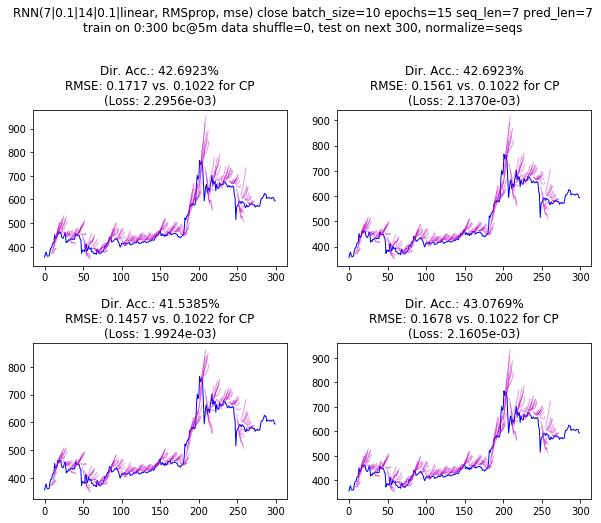

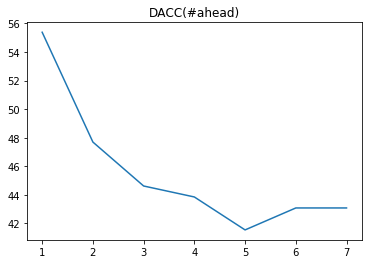

--- 293.490s to run experiment



In [45]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data24h,
        features=['close'],
        from_i=0,
        train_sz=300,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor([7, 0.1, 14, 0.1]),
        # training:
        epochs=15,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

## Full runs

In [46]:
len(data24h) - 600

751

In [ ]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data24h,
        features=['close'],
        from_i=0,
        train_sz=300,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor([3, 0.1, 3, 0.1]),
        # training:
        epochs=6,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

In [18]:
DEFAULT_PARAMS = {
    # data to extract:
    'data_df': data24h,
    'features': ['close'],
    'train_sz': 300,
    'test_sz': 300,
    # data processing:
    'normalize': 'seqs',  # 'seqs' | 'data'
    'detrend': False,
    # model and prediction arrangement:
    'seq_len': 7,
    'pred_len': 7,
    'model_maker': make_rnn_model_constructor([3, 0.1, 3, 0.1]),
    # training:
    'epochs': 3,
    'batch_size': 10,
    'shuffle': False,
    # experiment setup:
    'times': 1,
    'skip': False,
    'fix_all_rngs_to': False,
    'fix_rngs_before_each': False,
    # plotting:
    'plot': True,
    'fig_size': (10, 8),
    'fast': True,
}

CSV_FIELDS = (
    'model_description',
    'train_from',
    'train_to',
    'test_on',
    'shuffle',
    'normalize',
    'training_loss',
    'rmse',
    'rmse_cp',
    'dir_acc',
)

In [14]:
def ddump(s):
    """Print to both notebook and system stdout."""
    os.write(1, s)
    print(s)

In [15]:
def full_run(idx_from, idx_to, write_csv_header, filename, runner):
    train_sz = DEFAULT_PARAMS['train_sz']
    test_sz = DEFAULT_PARAMS['test_sz']
    
    out_file = open(filename, 'ab')
    csv_writer = csv.DictWriter(out_file, fieldnames=CSV_FIELDS)
    if write_csv_header:
        csv_writer.writeheader()
        
    with timing('full run %d - %d' % (idx_from, idx_to)):
        for i in range(idx_from, idx_to, test_sz):
            params = dict(DEFAULT_PARAMS,
                          from_i=i - train_sz)
            ddump("\n   ------ RUN %d (from %s, train on %d, test on %d)\n" % (
                i, params['from_i'], params['train_sz'], params['test_sz']))
            with timing('run segment'):
                out = runner(**params)
                csv_writer.writerow(out)
                out_file.flush()


   ------ RUN 300 (from 0, train on 300, test on 300)

data ~ (600, 1)

====== 0
                x_train_seqs ~ (292, 7, 1) [...0.0101538461538]
                y_train ~ (292, 1) [...[0.09661538]]
                x_test_seqs ~ (1, 7, 1) [...0.0165544332211]
                y_test ~ (1, 1) [...[0.07940516]]
                
--- 0.015s to model compilation time


--- Created model id: 140086789219216
Tensor("lstm_17_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 7, 3)              60        
_________________________________________________________________
dropout_17 (Dropout)         (None, 7, 3)              0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 3)                 84        
_________________________________________________________________
dropout_18

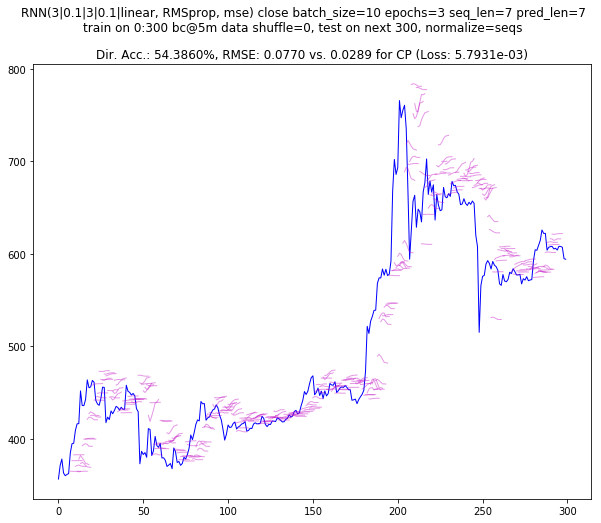

--- 11950.165s to run segment

--- 11950.166s to full run 300 - 600



In [19]:
full_run(300, 600,
    write_csv_header=False,
    filename=OUT_FILENAME,
    runner=run_walk_forward_validation_rnn_retraining
)

In [62]:
dd(pd.read_csv(OUT_FILENAME))

,model_description,train_from,train_to,test_on,shuffle,normalize,training_loss,rmse,rmse_cp,dir_acc
0,"RNN(3|0.1|3|0.1|linear, RMSprop, mse) close ba...",0,300,300,False,seqs,0.004466,0.0727%,0.1022%,70.0000%
1,"RNN(3|0.1|3|0.1|linear, RMSprop, mse) close ba...",300,600,300,False,seqs,0.004734,0.0834%,0.1147%,79.6154%
2,"RNN(3|0.1|3|0.1|linear, RMSprop, mse) close ba...",600,900,300,False,seqs,0.007003,0.1487%,0.1967%,77.3077%


In [ ]:
full_run(300, 1051, write_csv_header=False, OUT_RETRAINED_FILENAME, run_walk_forward_validation_rnn_retraining)

In [ ]:
dd(pd.read_csv(OUT_RETRAINED_FILENAME))